In [1]:
%pip install osmnx
%pip install contextily
%pip install networkx

  Using cached osmnx-2.0.1-py3-none-any.whl.metadata (4.9 kB)
Using cached osmnx-2.0.1-py3-none-any.whl (99 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached contextily-1.6.2-py3-none-any.whl.metadata (2.9 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl.metadata (4.8 kB)
Using cached contextily-1.6.2-py3-none-any.whl (17 kB)
Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
import osmnx as ox
import contextily

import networkx as nx
import matplotlib.pyplot as plt
import scipy.linalg as la
import numpy as np
import pandas as pd

In [3]:
north = 49.314886
south = 49.1754210
east = -123.002603
west = -123.267771

bounding_box = (west,south,east,north)

G = ox.graph.graph_from_bbox(bounding_box, network_type = 'drive')

In [4]:
def plot_graph(f,ax,edges):
    edges.plot(linewidth=.25, ax=ax, color='k', alpha=0.2)
    contextily.add_basemap(ax=ax,
                        crs=edges.crs,
                        source = contextily.providers.CartoDB.Voyager)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

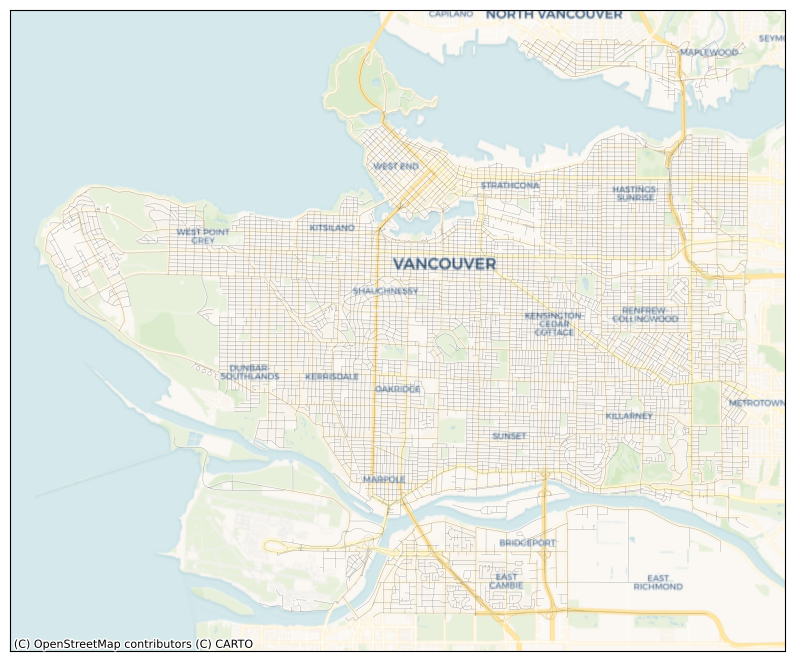

In [5]:
nodes, edges  = ox.graph_to_gdfs(G)

f,ax = plt.subplots(1,1, figsize=(10,10))
plot_graph(f,ax,edges)

In [6]:
stores_downtown = [
    (49.291074726223876, -123.1345112715533),
    (49.285778717275015, -123.1388610469531),
    (49.28543824009544, -123.12140394834859),
    (49.288086333967435, -123.11403832867163),
    (49.28108749140217, -123.12134595134327),
    (49.27953626208601, -123.1155462508102),
    (49.28131449647768, -123.10713668503729)
]

stores_van = [
    (49.26710745424008, -123.24276573624313),
    (49.26495239140005, -123.17770621538237),
    (49.269395328423684, -123.15949483697254),
    (49.264310005956226, -123.13849432853601),
    (49.236563149786534, -123.1543967279795)
]

stores_eastvan = [
    (49.265501224782504, -123.1167840944718),  
    (49.264156985091404, -123.06992053669686),  
    (49.260348107095176, -123.04365634497684),  
    (49.26762952939976, -123.02494525414363),  
    (49.24711277560665, -123.10169652190295),  
    (49.24640207307076, -123.06359221703782),  
    (49.23452058476019, -123.06597739540537),  
    (49.207897379250966, -123.12469600383916),  
    (49.21458384969505, -123.10853491891567),  
    (49.22126941578986, -123.07746972234048),
    (49.272454228734645, -123.1004652050492),  
    (49.281730801002375, -123.03062404165448)
]

depot = [(49.19415257260286, -123.17518597496046)]

all_locations = depot + stores_downtown + stores_van + stores_eastvan
len(all_locations[1:])

24

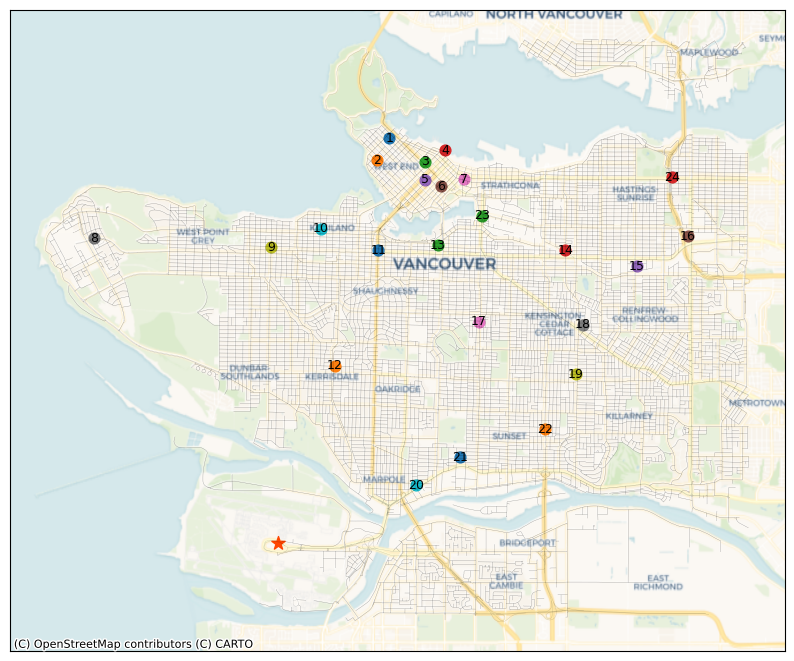

In [7]:
f,ax = plt.subplots(1,1, figsize=(10,12))

def plot_graph_with_all_locations(f,ax,edges):
    plot_graph(f,ax,edges)
    
    # Plot depot
    latitude, longitude = all_locations[0]
    ax.scatter(longitude, latitude, s=100, marker='*', color = 'orangered', label='Depot')
    
    # Plot other stores
    for i, point in enumerate(all_locations[1:], start=1):
        latitude,longitude = point
        ax.scatter(longitude,latitude,s=60)
        ax.text(longitude, latitude, str(i), fontsize=9, color='k', ha='center', va='center')

plot_graph_with_all_locations(f,ax,edges)
plt.show()

f.savefig("figs/map.jpg", dpi=300, bbox_inches='tight')

In [8]:
important_nodes = [ox.distance.nearest_nodes(G, point[1],point[0]) 
                   for point in all_locations]
G = ox.distance.add_edge_lengths(G)

In [9]:
shortest_paths = [[nx.shortest_path(G,node_0,node_1,weight='length') 
                   for node_1 in important_nodes] for node_0 in important_nodes]
shortest_path_lengths = np.array([
    [nx.shortest_path_length(G,node_0,node_1,weight='length') for node_1 in important_nodes]
    for node_0 in important_nodes
])

## Basic Model: Single-Vehicle Routing with a Central Depot

In [10]:
def get_path_edges(path_nodes,edges):
    edge_list = [(path_nodes[j],path_nodes[j+1]) for j in range(len(path_nodes)-1)]
    return edges[edges.index.isin(edge_list)]

def plot_paths(f,ax,tour,shortest_paths,lwidth):
    for i in range(len(tour)-1):
        shortest_path_edges = get_path_edges(shortest_paths[tour[i]][tour[i+1]],edges)
        shortest_path_edges.plot(linewidth=lwidth, ax=ax, color='b')

def cost_matrix(V):
    n = V.shape[0]
    C = np.zeros((n,n))
    for i in range(1,n):
        for j in range(0,i):
            C[i,j] = np.sqrt((V[j,0] - V[i,0])**2 + (V[j,1] - V[i,1])**2)
            C[j,i] = C[i,j]
    return C

def tour_cost(C,tour):
    n = len(tour)
    cost = 0
    for i in range(n-1):
        cost += C[tour[i],tour[i+1]]
    return cost

def nearest_neighbor(V,start=0, C = None):
    n = V.shape[0]
    if C is None:
        C = cost_matrix(V)
    tour = [start]
    nodes = list(range(n))
    nodes.remove(start)
    for i in range(1,n):
        next_i = np.argmin(C[tour[-1],nodes])
        next_node = nodes[next_i]
        tour.append(next_node)
        nodes.pop(next_i)
    tour.append(start)
    cost = tour_cost(C,tour)
    return tour,cost

In [11]:
V = np.array(all_locations)

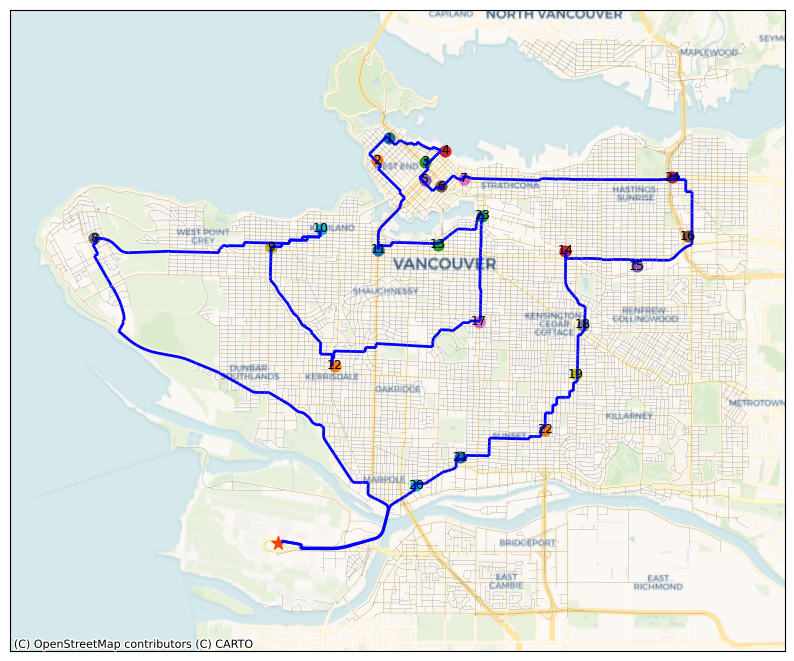

Tour: [0, 20, 21, 22, 19, 18, 14, 15, 16, 24, 7, 6, 5, 3, 4, 1, 2, 11, 13, 23, 17, 12, 9, 10, 8, 0]
Cost(km): 75.18


In [12]:
tour,cost = nearest_neighbor(V,start = 0, C=shortest_path_lengths)

f,ax = plt.subplots(1,1, figsize=(10,10))
plot_graph_with_all_locations(f,ax,edges)
plot_paths(f,ax,tour,shortest_paths,2)
f.savefig("figs/single_result.jpg", dpi=300, bbox_inches='tight')
plt.show()

print(
    f'Tour: {tour}\n'
    f'Cost(km): {cost/1000:.2f}'
)

## Intermediate Model: Dual-Vehicle Routing with a Shared Depot

### The Splitting Algorithm

In [13]:
def nearest_neighbor_two_trucks(V,start=0,C=None,a=0):
    '''
    One truck visits n/2 stores, the other visit the remaining n/2 stores
    '''
    n = V.shape[0]
    m1 = int(np.floor((n-1)/2))+1+a
    m2 = n-m1+1
    
    tour1 = [start]
    nodes = list(range(n))
    nodes.remove(start)
    for i in range(1,m1):
        next_i = np.argmin(C[tour1[-1],nodes])
        next_node = nodes[next_i]
        tour1.append(next_node)
        nodes.pop(next_i)

    tour2 = [start]
    for i in range(1,m2):
        next_i = np.argmin(C[tour2[-1],nodes])
        next_node = nodes[next_i]
        tour2.append(next_node)
        nodes.pop(next_i)
    
    tour1.append(tour[0])
    tour2.append(tour[0])
    tours = [tour1, tour2]

    costs = [tour_cost(C,tour1), tour_cost(C,tour2)]
    
    return tours,costs

def plot_2paths(f,ax,tours,shortest_paths,lwidth=2):
    colors = ['royalblue', 'orangered']
    for i, tour in enumerate(tours):
        for j in range(len(tour)-1):
            shortest_path_edges = get_path_edges(shortest_paths[tour[j]][tour[j+1]],edges)
            shortest_path_edges.plot(linewidth=lwidth, ax=ax, color=colors[i])

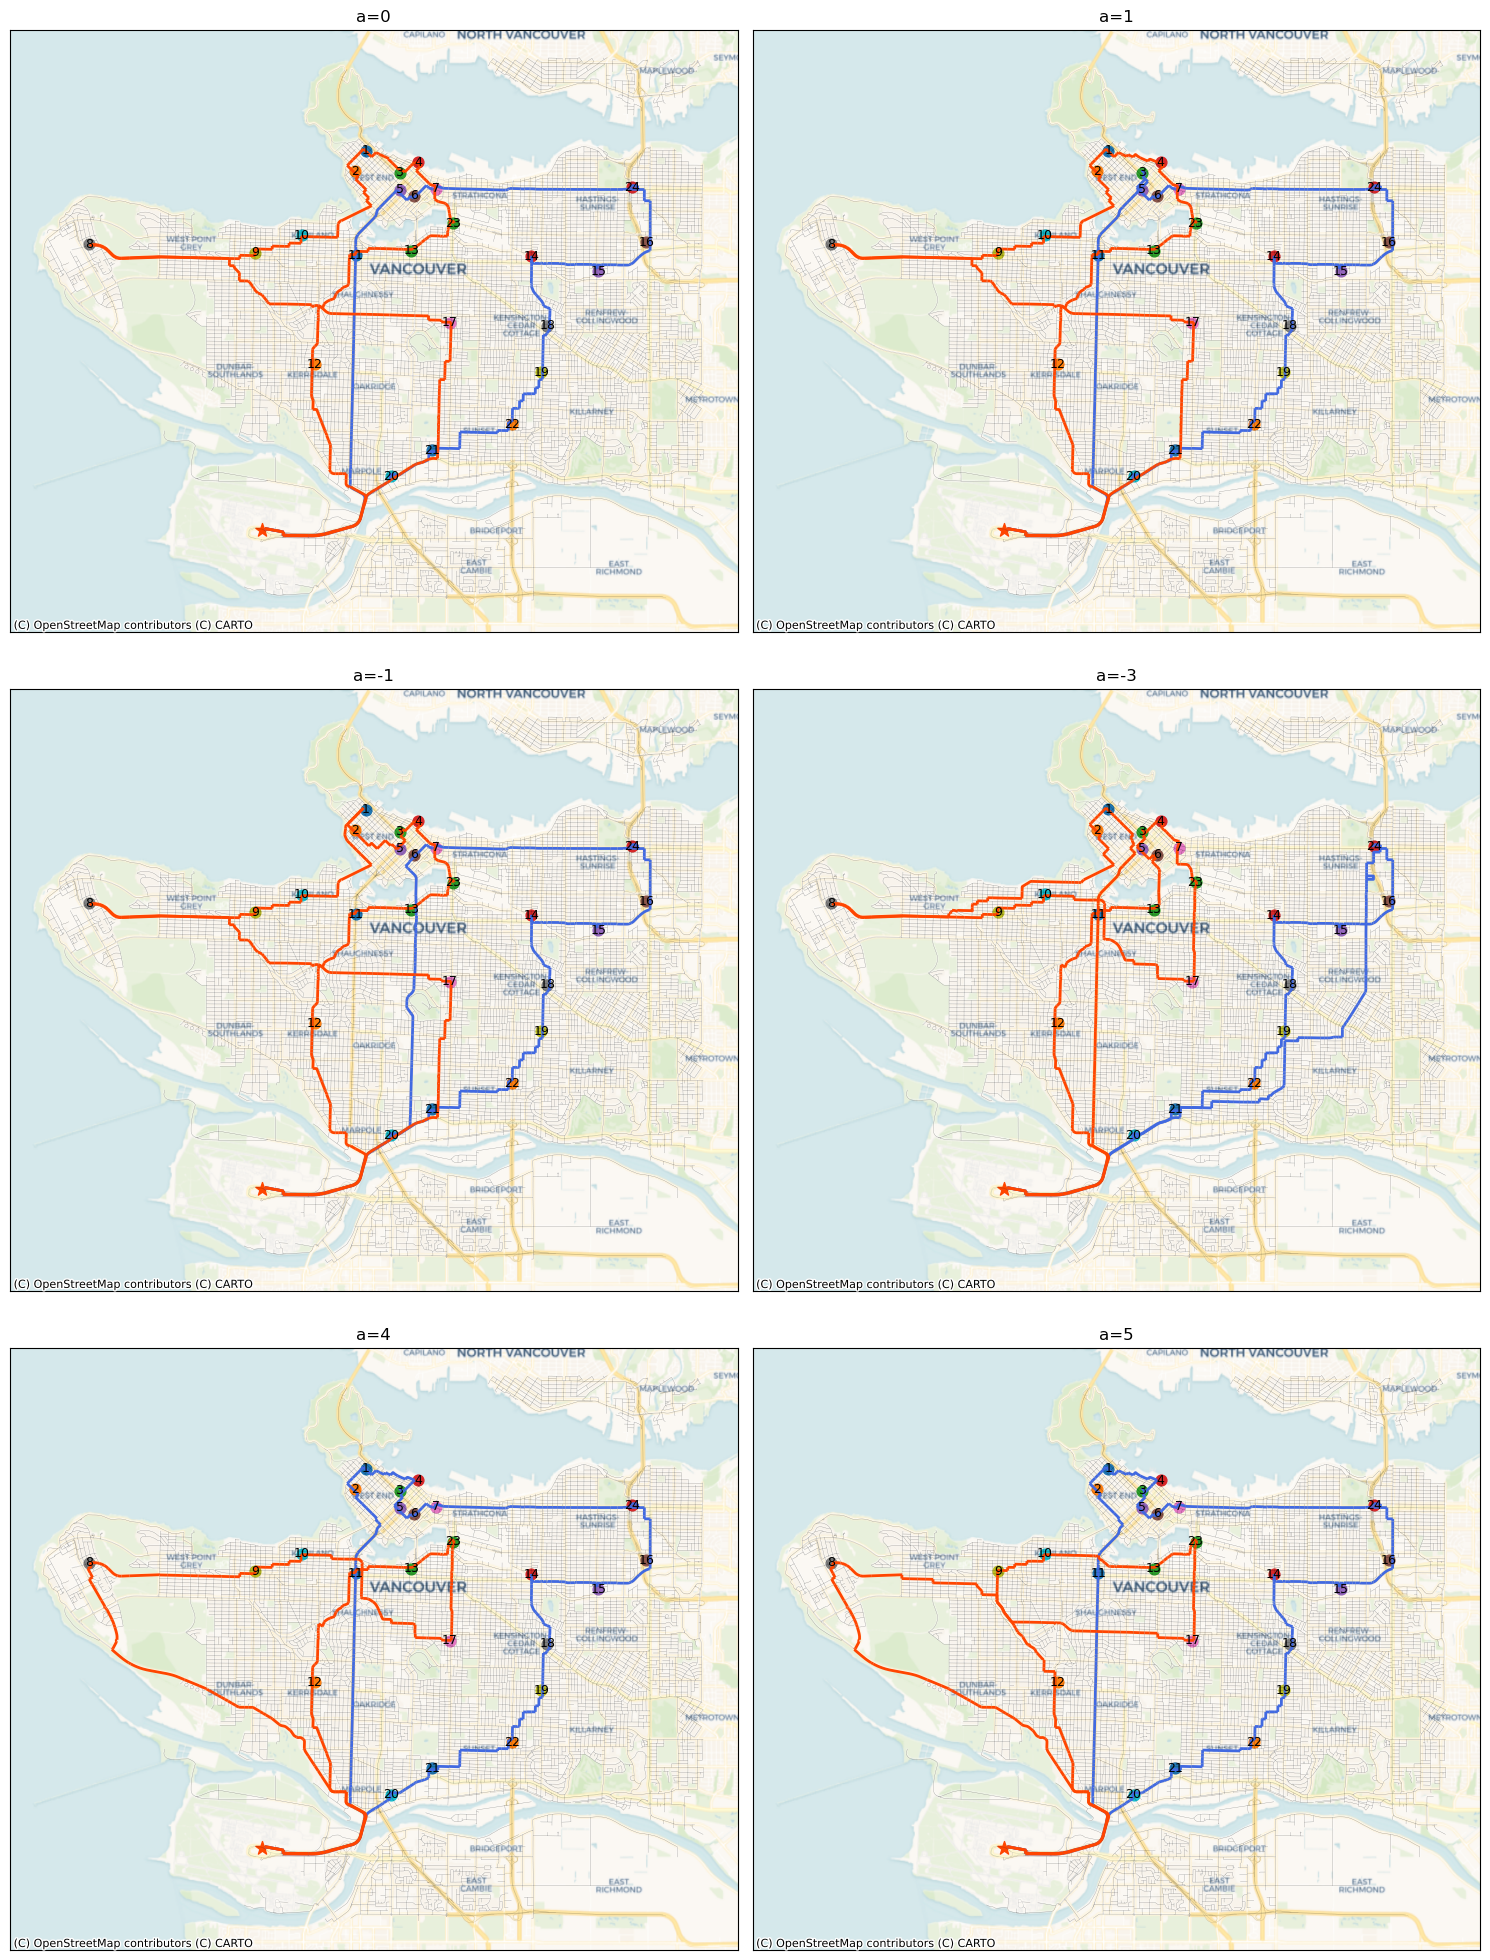

a value Number of Stores Visited       Costs(km)  Total Cost(km)
0        0                 (12, 12)  (41.89, 52.85)           94.73
1        1                 (13, 11)   (43.46, 52.6)           96.06
2       -1                 (11, 13)  (41.33, 54.65)           95.98
3       -3                  (9, 15)  (40.05, 61.52)          101.58
4        4                  (16, 8)  (46.61, 46.72)           93.32
5        5                  (17, 7)  (46.61, 48.63)           95.23

In [29]:
f, axes = plt.subplots(3, 2, figsize=(15, 20))
a_values = [0, 1, -1, -3, 4, 5]

results = {"a value": a_values, "tours": [], "Number of Stores Visited": [], "Costs(km)": [], "Total Cost(km)": []}

for i, a in enumerate(a_values):
    tours, costs = nearest_neighbor_two_trucks(V, start=0, C=shortest_path_lengths, a=a)
    row, col = divmod(i, 2)
    
    plot_graph_with_all_locations(f, axes[row, col], edges)
    plot_2paths(f, axes[row, col], tours, shortest_paths)
    axes[row, col].set_title(f'a={a}')
    
    results["tours"].append(tours)
    results["Number of Stores Visited"].append((len(tours[0])-2, len(tours[1])-2))
    results["Costs(km)"].append((round(costs[0]/1000, 2), round(costs[1]/1000, 2)))
    results["Total Cost(km)"].append(round(sum(costs)/1000, 2))

plt.tight_layout()
f.savefig("figs/comparison_result.jpg", dpi=300, bbox_inches='tight')
plt.show()

# results
full_results = pd.DataFrame(results)
results_short = full_results.drop(columns=['tours'])
results_short

In [41]:
n = full_results.shape[0]
for i in range(n):
    print(f'a={full_results.iloc[i,0]}\n'
         f'tour1: {full_results.iloc[i,1][0]}\n'
         f'tour2: {full_results.iloc[i,1][1]}\n')

a=0
tour1: [0, 20, 21, 22, 19, 18, 14, 15, 16, 24, 7, 6, 5, 0]
tour2: [0, 12, 11, 13, 23, 4, 3, 1, 2, 10, 9, 8, 17, 0]

a=1
tour1: [0, 20, 21, 22, 19, 18, 14, 15, 16, 24, 7, 6, 5, 3, 0]
tour2: [0, 12, 11, 13, 23, 4, 1, 2, 10, 9, 8, 17, 0]

a=-1
tour1: [0, 20, 21, 22, 19, 18, 14, 15, 16, 24, 7, 6, 0]
tour2: [0, 12, 11, 13, 23, 4, 3, 5, 2, 1, 10, 9, 8, 17, 0]

a=-3
tour1: [0, 20, 21, 22, 19, 18, 14, 15, 16, 24, 0]
tour2: [0, 12, 11, 13, 6, 5, 3, 4, 7, 23, 17, 10, 9, 8, 2, 1, 0]

a=4
tour1: [0, 20, 21, 22, 19, 18, 14, 15, 16, 24, 7, 6, 5, 3, 4, 1, 2, 0]
tour2: [0, 12, 11, 13, 23, 17, 10, 9, 8, 0]

a=5
tour1: [0, 20, 21, 22, 19, 18, 14, 15, 16, 24, 7, 6, 5, 3, 4, 1, 2, 11, 0]
tour2: [0, 12, 9, 10, 13, 23, 17, 8, 0]



### The Alternating Algorithm

Car 1 distance: 45555.68307566587
Car 2 distance: 45610.95532495402
Total distance: 91166.63840061988


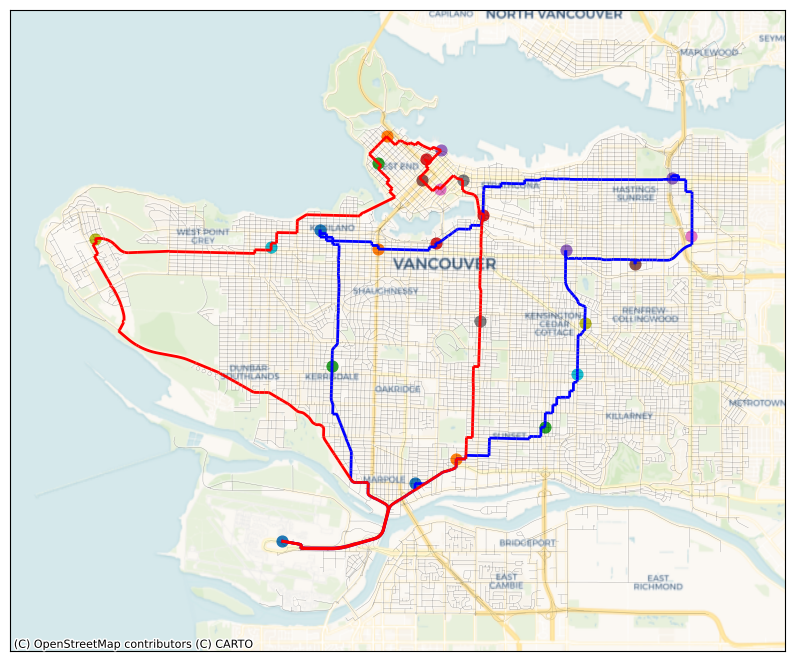

In [18]:
all_points = all_locations
all_nodes = [ox.distance.nearest_nodes(G, lon, lat) for lat, lon in all_points]

distance_matrix = np.array([
    [nx.shortest_path_length(G, node_from, node_to, weight='length') 
     for node_to in all_nodes] 
    for node_from in all_nodes
])


def greedy_two_car_routing(dist_matrix):
    n_points = dist_matrix.shape[0]
    unvisited = set(range(1, n_points))
    routes = [[0], [0]]
    distances = [0, 0]
    car_turn = 0
    while unvisited:
        last_point = routes[car_turn][-1]
        nearest_point = min(unvisited, key=lambda p: dist_matrix[last_point, p])
        routes[car_turn].append(nearest_point)
        distances[car_turn] += dist_matrix[last_point, nearest_point]
        unvisited.remove(nearest_point)
        car_turn = 1 - car_turn
    for car in [0, 1]:
        last_point = routes[car][-1]
        distances[car] += dist_matrix[last_point, 0]
        routes[car].append(0)
    return routes, distances


def plot_two_car_routes(G, edges, all_nodes, routes, color_list=['blue', 'red']):
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    plot_graph(f, ax, edges)
    for node in all_nodes:
        x = G.nodes[node]['x']
        y = G.nodes[node]['y']
        ax.scatter(x, y, s=60)
    for car_idx, route in enumerate(routes):
        for i in range(len(route) - 1):
            path_nodes = nx.shortest_path(G, all_nodes[route[i]], all_nodes[route[i+1]], weight='length')
            path_edges = get_path_edges(path_nodes, edges)
            path_edges.plot(linewidth=2, ax=ax, color=color_list[car_idx])
    f.savefig("figs/alter_result.jpg", dpi=300, bbox_inches='tight')
    plt.show()

routes, distances = greedy_two_car_routing(distance_matrix)

print("Car 1 distance:", distances[0])
print("Car 2 distance:", distances[1])
print("Total distance:", np.sum(distances))

plot_two_car_routes(G, edges, all_nodes, routes)

## Advanced Model: Dual-Vehicle Routing with Dual Depots

In [ ]:
from sklearn.cluster import KMeans

allstores = stores_downtown + stores_van + stores_eastvan
X = np.array(allstores)

# k-means 
def balanced_kmeans_2(X, max_diff=2, random_state=0):
    kmeans = KMeans(n_clusters=2, random_state=random_state).fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    while True:
        c0_idx = np.where(labels==0)[0]
        c1_idx = np.where(labels==1)[0]
        diff = abs(len(c0_idx) - len(c1_idx))
        if diff <= max_diff:
            break
        # 找出簇大小不平衡部分（bigger 与 smaller）
        bigger = 0 if len(c0_idx)>len(c1_idx) else 1
        smaller = 1 - bigger
        bigger_idx = np.where(labels==bigger)[0]
        # 计算每个点对两个质心的距离，然后根据距离调整标签
        dist_big   = np.linalg.norm(X[bigger_idx] - centers[bigger], axis=1)
        dist_small = np.linalg.norm(X[bigger_idx] - centers[smaller], axis=1)
        delta_dist = dist_small - dist_big
        order = np.argsort(delta_dist)
        # 将较大簇中的点分配到较小的簇，直到两簇数量差在max_diff以内 ; control the max number gap between two clusters
        for idx_in_bigger in order:
            real_idx = bigger_idx[idx_in_bigger]
            labels[real_idx] = smaller
            if abs(np.sum(labels==0) - np.sum(labels==1)) <= max_diff:
                break
        # change center position        
        for c in [0,1]:
            group = X[labels==c]
            if len(group)>0:
                centers[c] = group.mean(axis=0)
    return labels, centers

labels, centers = balanced_kmeans_2(X, max_diff=2, random_state=42)


def clip_to_bbox(lat, lon, north, south, east, west):
    lat_clip = max(south, min(north, lat))
    lon_clip = max(west,  min(east,  lon))
    return (lat_clip, lon_clip)


    
# warehouse location by k-means 
wh1 = clip_to_bbox(centers[0,0], centers[0,1], north, south, east, west)
wh2 = clip_to_bbox(centers[1,0], centers[1,1], north, south, east, west)

warehouse_node_1 = ox.distance.nearest_nodes(G, wh1[1], wh1[0]) 
warehouse_node_2 = ox.distance.nearest_nodes(G, wh2[1], wh2[0])



# assign stores to warehouse produce cluster
cluster_0_points = X[labels==0]
cluster_1_points = X[labels==1]

cluster_0_nodes = [warehouse_node_1]
cluster_1_nodes = [warehouse_node_2]

for (lat, lon) in cluster_0_points:
    n = ox.distance.nearest_nodes(G, lon, lat)
    cluster_0_nodes.append(n)

for (lat, lon) in cluster_1_points:
    n = ox.distance.nearest_nodes(G, lon, lat)
    cluster_1_nodes.append(n)




# Calculate the shortest path distance between all nodes in the cluster for subsequent path planning
def build_dist_matrix(G, nodes):
    n = len(nodes)
    M = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i!=j:
                M[i,j] = nx.shortest_path_length(G, nodes[i], nodes[j], weight='length')
    return M

dist0 = build_dist_matrix(G, cluster_0_nodes)
dist1 = build_dist_matrix(G, cluster_1_nodes)




# routing strategy
def greedy_one_car_routing(dist_mat):
    n_points = dist_mat.shape[0]
    unvisited = set(range(1, n_points))
    route = [0]
    total_dist = 0
    while unvisited:
        last_p = route[-1]
        nearest = min(unvisited, key=lambda p: dist_mat[last_p,p])
        route.append(nearest)
        total_dist += dist_mat[last_p, nearest]
        unvisited.remove(nearest)
    total_dist += dist_mat[route[-1], 0]
    route.append(0)
    return route, total_dist

route_idx_0, cost0 = greedy_one_car_routing(dist0)
route_idx_1, cost1 = greedy_one_car_routing(dist1)
print("Car1 distance =", cost0)
print("Car2 distance =", cost1)


def build_full_path(G, nodes, route_idx):
    fullpath = []
    for i in range(len(route_idx)-1):
        start_i = route_idx[i]
        end_i   = route_idx[i+1]
        seg = nx.shortest_path(G, nodes[start_i], nodes[end_i], weight='length')
        if i==0:
            fullpath.extend(seg)
        else:
         
            fullpath.extend(seg[1:])
    return fullpath

route_nodes_0 = build_full_path(G, cluster_0_nodes, route_idx_0)
route_nodes_1 = build_full_path(G, cluster_1_nodes, route_idx_1)



#visualization; same with upper case
def plot_two_car_routes(G, route_nodes_0, route_nodes_1, allstores, color_list=['blue', 'red']):
    fig, ax = ox.plot_graph(G,
                            show=False,
                            close=False,
                            bgcolor='white',
                            node_color='none',
                            edge_color='gray',
                            edge_linewidth=0.5,
                            figsize=(12, 12))

    ox.plot_graph_route(G,
                        route_nodes_0,
                        route_color=color_list[0],
                        route_linewidth=3,
                        orig_dest_node_size=80,
                        ax=ax,
                        show=False,
                        close=False)

    ox.plot_graph_route(G,
                        route_nodes_1,
                        route_color=color_list[1],
                        route_linewidth=3,
                        orig_dest_node_size=80,
                        ax=ax,
                        show=False,
                        close=False)

    for (lat, lon) in allstores:
        ax.scatter(lon, lat, c='black', s=40, marker='o', zorder=5)

    plt.savefig("figs/routes_with_stores.jpg", dpi=300, bbox_inches='tight')
    plt.show()

plot_two_car_routes(G, route_nodes_0, route_nodes_1, allstores)

Car1 distance = 38068.94821072665
Car2 distance = 34544.620157549376


Car 1 Distance (km): 46605.01787509449
Car 2 Distance (km): 46717.028964776735
Total Distance (km): 93322.04683987123


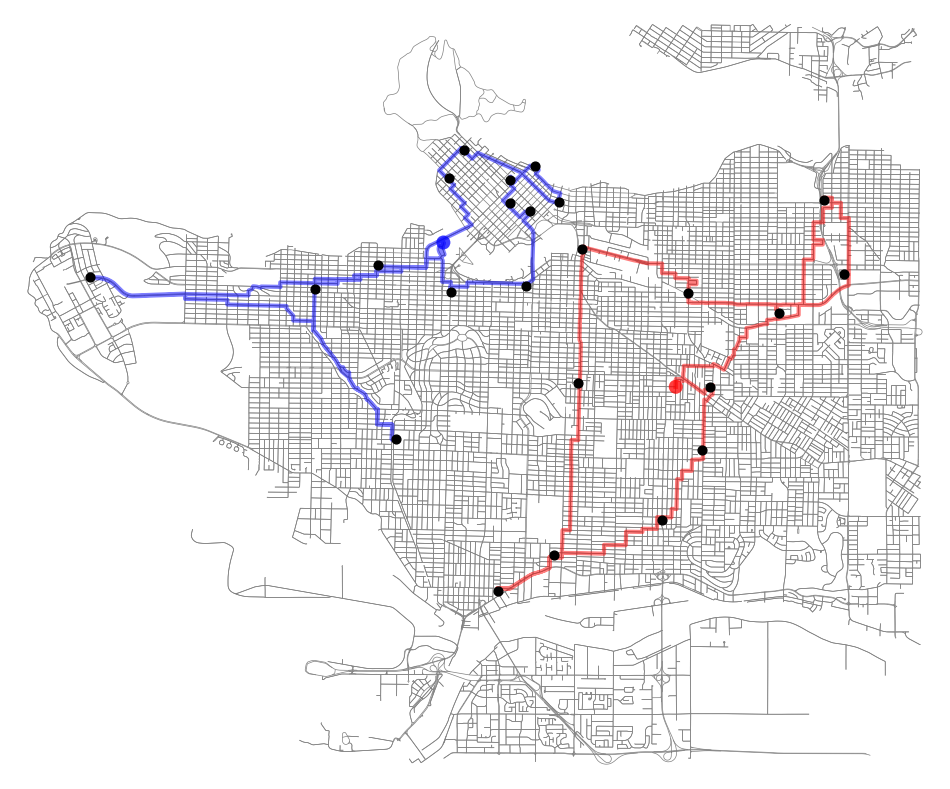

In [46]:
from sklearn.cluster import KMeans

allstores = stores_downtown + stores_van + stores_eastvan
X = np.array(allstores)

# k-means 
def balanced_kmeans_2(X, max_diff=2, random_state=0):
    kmeans = KMeans(n_clusters=2, random_state=random_state).fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    while True:
        c0_idx = np.where(labels==0)[0]
        c1_idx = np.where(labels==1)[0]
        diff = abs(len(c0_idx) - len(c1_idx))
        if diff <= max_diff:
            break
        # 找出簇大小不平衡部分（bigger 与 smaller）
        bigger = 0 if len(c0_idx)>len(c1_idx) else 1
        smaller = 1 - bigger
        bigger_idx = np.where(labels==bigger)[0]
        # 计算每个点对两个质心的距离，然后根据距离调整标签
        dist_big   = np.linalg.norm(X[bigger_idx] - centers[bigger], axis=1)
        dist_small = np.linalg.norm(X[bigger_idx] - centers[smaller], axis=1)
        delta_dist = dist_small - dist_big
        order = np.argsort(delta_dist)
        # 将较大簇中的点分配到较小的簇，直到两簇数量差在max_diff以内 ; control the max number gap between two clusters
        for idx_in_bigger in order:
            real_idx = bigger_idx[idx_in_bigger]
            labels[real_idx] = smaller
            if abs(np.sum(labels==0) - np.sum(labels==1)) <= max_diff:
                break
        # change center position        
        for c in [0,1]:
            group = X[labels==c]
            if len(group)>0:
                centers[c] = group.mean(axis=0)
    return labels, centers

labels, centers = balanced_kmeans_2(X, max_diff=2, random_state=42)


def clip_to_bbox(lat, lon, north, south, east, west):
    lat_clip = max(south, min(north, lat))
    lon_clip = max(west,  min(east,  lon))
    return (lat_clip, lon_clip)


    
# warehouse location by k-means 
wh1 = clip_to_bbox(centers[0,0], centers[0,1], north, south, east, west)
wh2 = clip_to_bbox(centers[1,0], centers[1,1], north, south, east, west)

warehouse_node_1 = ox.distance.nearest_nodes(G, wh1[1], wh1[0]) 
warehouse_node_2 = ox.distance.nearest_nodes(G, wh2[1], wh2[0])



# assign stores to warehouse produce cluster
cluster_0_points = X[labels==0]
cluster_1_points = X[labels==1]

cluster_0_nodes = [warehouse_node_1]
cluster_1_nodes = [warehouse_node_2]

for (lat, lon) in cluster_0_points:
    n = ox.distance.nearest_nodes(G, lon, lat)
    cluster_0_nodes.append(n)

for (lat, lon) in cluster_1_points:
    n = ox.distance.nearest_nodes(G, lon, lat)
    cluster_1_nodes.append(n)




# Calculate the shortest path distance between all nodes in the cluster for subsequent path planning
def build_dist_matrix(G, nodes):
    n = len(nodes)
    M = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i!=j:
                M[i,j] = nx.shortest_path_length(G, nodes[i], nodes[j], weight='length')
    return M

dist0 = build_dist_matrix(G, cluster_0_nodes)
dist1 = build_dist_matrix(G, cluster_1_nodes)




# routing strategy use first case
warehouse_0_index = np.argmin(np.linalg.norm(cluster_0_points - centers[0], axis=1))
warehouse_1_index = np.argmin(np.linalg.norm(cluster_1_points - centers[1], axis=1))

tour_0, cost_0 = nearest_neighbor(cluster_0_points, start=warehouse_0_index)
tour_1, cost_1 = nearest_neighbor(cluster_1_points, start=warehouse_1_index)
print(
    f'Car 1 Distance (km): {costs[0]}\n'
    f'Car 2 Distance (km): {costs[1]}\n'
    f'Total Distance (km): {sum(costs)}'
)


    
# def build_full_path(G, nodes, route_idx):
#     fullpath = []
#     for i in range(len(route_idx)-1):
#         start_i = route_idx[i]
#         end_i   = route_idx[i+1]
#         seg = nx.shortest_path(G, nodes[start_i], nodes[end_i], weight='length')
#         if i==0:
#             fullpath.extend(seg)
#         else:
         
#             fullpath.extend(seg[1:])
#     return fullpath

# route_nodes_0 = build_full_path(G, cluster_0_nodes, route_idx_0)
# route_nodes_1 = build_full_path(G, cluster_1_nodes, route_idx_1)



#visualization; same with upper case
def plot_two_car_routes(G, route_nodes_0, route_nodes_1, allstores, color_list=['blue', 'red']):
    fig, ax = ox.plot_graph(G,
                            show=False,
                            close=False,
                            bgcolor='white',
                            node_color='none',
                            edge_color='gray',
                            edge_linewidth=0.5,
                            figsize=(12, 12))

    ox.plot_graph_route(G,
                        route_nodes_0,
                        route_color=color_list[0],
                        route_linewidth=3,
                        orig_dest_node_size=80,
                        ax=ax,
                        show=False,
                        close=False)

    ox.plot_graph_route(G,
                        route_nodes_1,
                        route_color=color_list[1],
                        route_linewidth=3,
                        orig_dest_node_size=80,
                        ax=ax,
                        show=False,
                        close=False)

    for (lat, lon) in allstores:
        ax.scatter(lon, lat, c='black', s=40, marker='o', zorder=5)

    plt.savefig("figs/routes_with_stores.jpg", dpi=300, bbox_inches='tight')
    plt.show()

plot_two_car_routes(G, route_nodes_0, route_nodes_1, allstores)